# Postprocessing Pipeline

---

This notebook shows our postprocessing pipeline for one example and compares it to the "ground truth" (i.e. labels directly extracted from the jams file). Please note: since this only uses one example, the generalized code is actually a bit more complex.

## Input

Input to postprocessing will be a list of arrays with shape 6x21. The list length will vary from song to song.

## Code

### Imports

In [1]:
# imports
import numpy as np
import pandas as pd
import IPython
import jams
import librosa
import matplotlib.pyplot as plt
import seaborn as sns

### Data

In [2]:
filename = '00_BN1-129-Eb_solo'
audiodata, sr = librosa.load('../data/raw/audio_mono-mic/' + filename + '_mic.wav')
jamsdata = jams.load('../data/raw/annotation/' + filename + '.jams')

### Get ground truth from jams files

In [3]:
# getting midi info from jams file
def midi_info_from_jams(data: jams.JAMS):
    n = []
    s = []
    for string, i in enumerate(data.annotations['note_midi']):
        for j in i['data']:
            n.append([string, *j[:-1]])

    return n

In [4]:
# adding fret column to notes_played_df
def find_frets_from_jams(notes_played, strings_used):
    tuning = [40, 45, 50, 55, 59, 64]
    notes = [n[3] for n in np.round(notes_played, 0)]
    fret = []
    for idx, i in enumerate(notes):
        if strings_used[idx] < 4:
            fret.append(int(notes[idx] - (40 + strings_used[idx] * 5)))
        elif strings_used[idx] >= 4:
            fret.append(int(notes[idx] - (39 + strings_used[idx] * 5)))
    
    return fret

In [5]:
# get midi info
notes_played = midi_info_from_jams(jamsdata)

# build dataframe
ground_truth_df = pd.DataFrame(notes_played, columns=['string', 'time', 'dur', 'midi'])

# cleaning midi information
ground_truth_df['midi'] = ground_truth_df['midi'].round(0).astype(int)

# adding frets
ground_truth_df['fret'] = find_frets_from_jams(notes_played, ground_truth_df['string'].values)

# reformatting dataframe
ground_truth_df = ground_truth_df.sort_values(by='time')
ground_truth_df = ground_truth_df.reset_index().drop('index', axis=1)

# adding positional information
ground_truth_df['pos'] = list(range(ground_truth_df.shape[0]))

In [6]:
ground_truth_df.head(10)

,string,time,dur,midi,fret,pos
0,2,0.008544,0.174150,56,6,0
1,0,0.009973,0.214785,46,6,1
2,1,0.015052,0.168345,51,6,2
3,1,0.186957,0.301859,53,8,3
4,2,0.187705,0.290249,58,8,4
5,1,0.497365,0.423764,52,7,5
6,2,0.498816,0.348299,52,2,6
7,1,0.928091,0.098685,52,7,7
8,1,1.027410,0.406349,53,8,8
9,2,1.438023,0.243810,57,7,9


### Convert ground truth to frame-level-labels

In [7]:
resolution = 1  # how many frames to consider
fps = 43
start = 0
interval = (resolution/fps)
n_frames = int(np.round(librosa.get_duration(y=audiodata, sr=sr) * fps))

frame_labels = []

for i in range(n_frames):
    lbound = i * interval
    rbound = (i+1) * interval
    labels = ground_truth_df[(ground_truth_df['time'] >= lbound) & (ground_truth_df['time'] <= rbound)][['string', 'fret']].values
    if labels.size > 0:
        frame_labels.append(labels)

frame_labels = np.array(frame_labels)

/var/folders/80/hwh06q8n6q14ph9lgk7hmtj00000gn/T/ipykernel_31078/2343164554.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  frame_labels = np.array(frame_labels)


In [8]:
frame_level_labels = pd.DataFrame(frame_labels).explode(0).reset_index()

In [9]:
frame_level_labels.head()

,index,0
0,0,"[2, 6]"
1,0,"[0, 6]"
2,0,"[1, 6]"
3,1,"[1, 8]"
4,1,"[2, 8]"


In [10]:
# format frame_level_labels
if len(frame_level_labels.columns) == 2:
    frame_level_labels.rename(mapper={'index': 'pos', 0: 'string'}, axis=1, inplace=True)
    frame_level_labels['fret'] = [i[1] for i in frame_level_labels['string'].values]
    frame_level_labels['string'] = [i[0] for i in frame_level_labels['string'].values]

else:
    frame_level_labels.rename(mapper={'index': 'pos', 0: 'string', 1: 'fret'}, axis=1, inplace=True)

In [11]:
frame_level_labels.head()

,pos,string,fret
0,0,2,6
1,0,0,6
2,0,1,6
3,1,1,8
4,1,2,8


### Build mock CNN output from frame-level-labels

In [12]:
def build_6x21(data: np.array):
    # data structure
    # index 0: position
    # index 1: string
    # index 2: fret

    r = np.zeros((data.shape[0], 6, 21))
    # loop over data
    for idx, i in enumerate(data):
        r[i[0]][i[1]][i[2]+1] = 1

    for widx, i in enumerate(r):
        for string, j in enumerate(i):
            if sum(j) == 0:
                r[widx][string][0] = 1

    return r

In [13]:
mock_output = build_6x21(np.array(frame_level_labels))

In [14]:
mock_output

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       [[1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       [[1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       [[1., 0., 0., ..., 0., 0., 0.],
    

### Build tabs from mock CNN output

In [15]:
def find_frets(labels):

    tabs = []
    
    # get indices where labeldata is 1
    idx = np.where(labels == 1)

    for position, window in enumerate(labels):
        for string, data in enumerate(window):
            idx = np.where(data[1:] == 1)
            if idx[0].size > 0:
                tabs.append([position, string, np.squeeze(idx[0][0])]) # [-1] is a quickfix for the error found above!

    return pd.DataFrame(tabs, columns=['pos', 'string', 'fret'])

In [16]:
postproc_df = find_frets(mock_output)

In [17]:
postproc_df.head()

,pos,string,fret
0,0,0,6
1,0,1,6
2,0,2,6
3,1,1,8
4,1,2,8


### Compare results to ground truth

#### Plotting function

In [18]:
def plot_tabs(data, idx_string, idx_fret, idx_pos):

    fig, ax = plt.subplots(figsize=(25, 6))
    tab_fig = sns.scatterplot(data=data, x='pos', y='string', marker="x", color='white', ax=ax)

    # rename yticks to string labels
    tab_fig.axes.set_yticks(list(range(6)))
    tab_fig.set_yticklabels(['E', 'A', 'D', 'G', 'B', 'e'])

    # remove xticks
    tab_fig.set_xticks([])

    # relabel x and y
    tab_fig.set_ylabel('String', size='large')
    tab_fig.set_xlabel("")

    # remove spines
    sns.despine(top=True, bottom=True, left=False, right=False)

    # add grid
    tab_fig.grid(which='major', axis='y', linestyle='-', color='gray')

    # add frets
    for note in data.values:
        tab_fig.annotate(text=str(int(note[idx_fret])), xy=(note[idx_pos], note[idx_string]-0.08), size='large', color="red") # can throw a FutureWarning: triggered by numpy. nothing much we can do about it.

#### Audio

In [19]:
IPython.display.Audio('../data/raw/audio_mono-mic/' + filename + '_mic.wav')

#### Results: Direct extraction from jams file

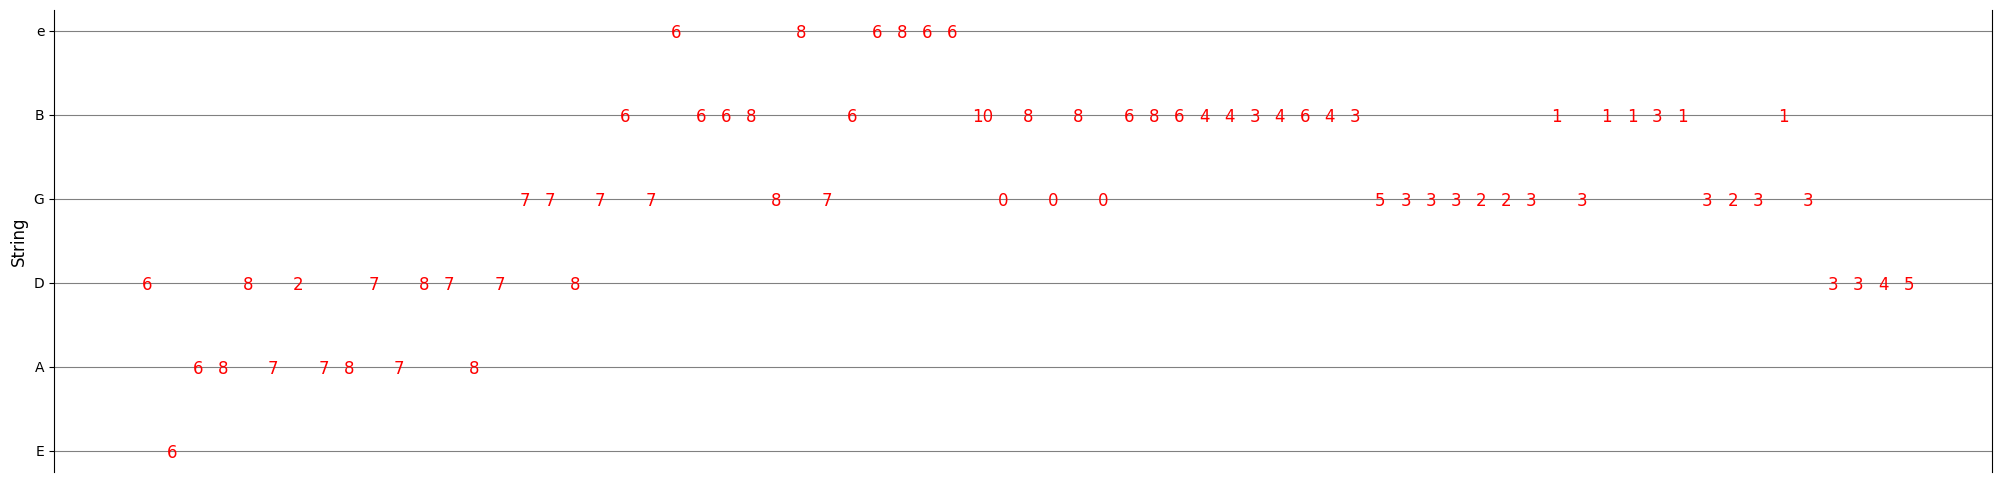

In [20]:
plot_tabs(ground_truth_df, idx_string=0, idx_pos=5, idx_fret=4)

#### Results: Frame-level extraction

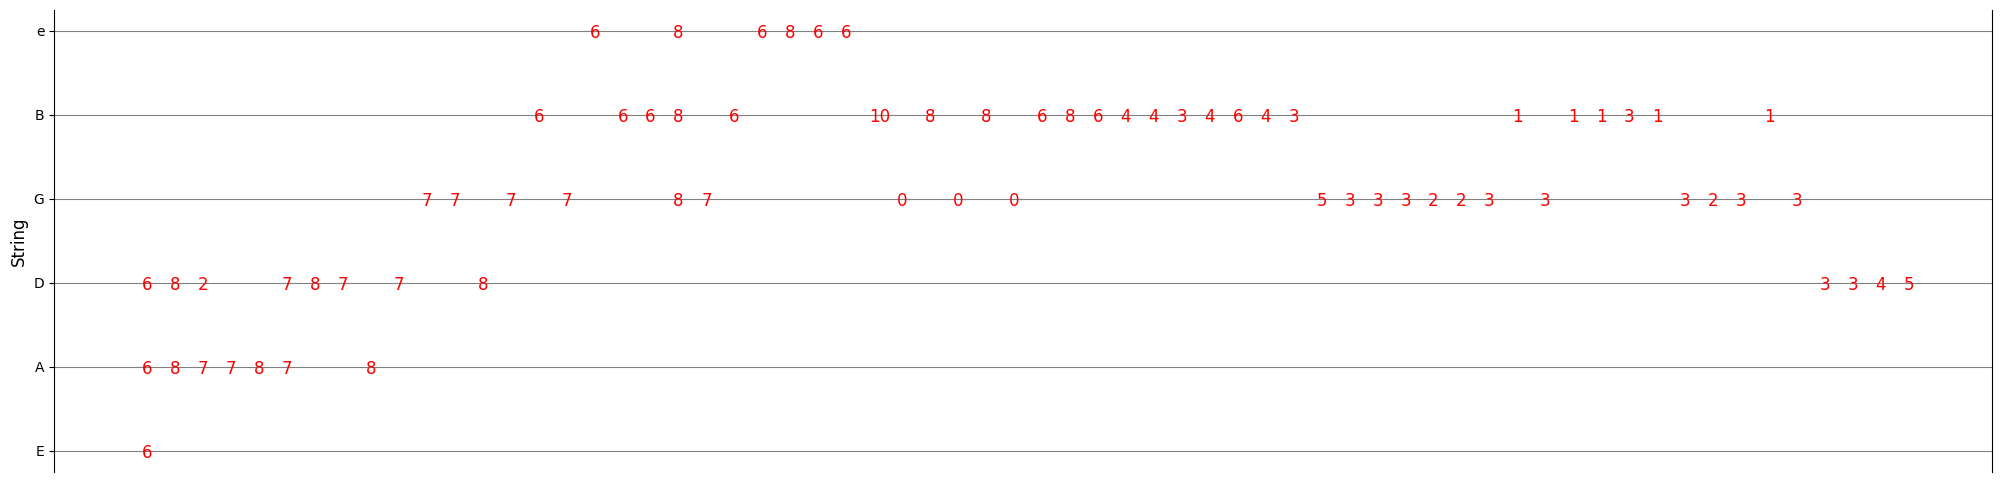

In [21]:
plot_tabs(frame_level_labels, idx_string=1, idx_fret=2, idx_pos=0)

#### Results: Extraction from mock CNN predictions

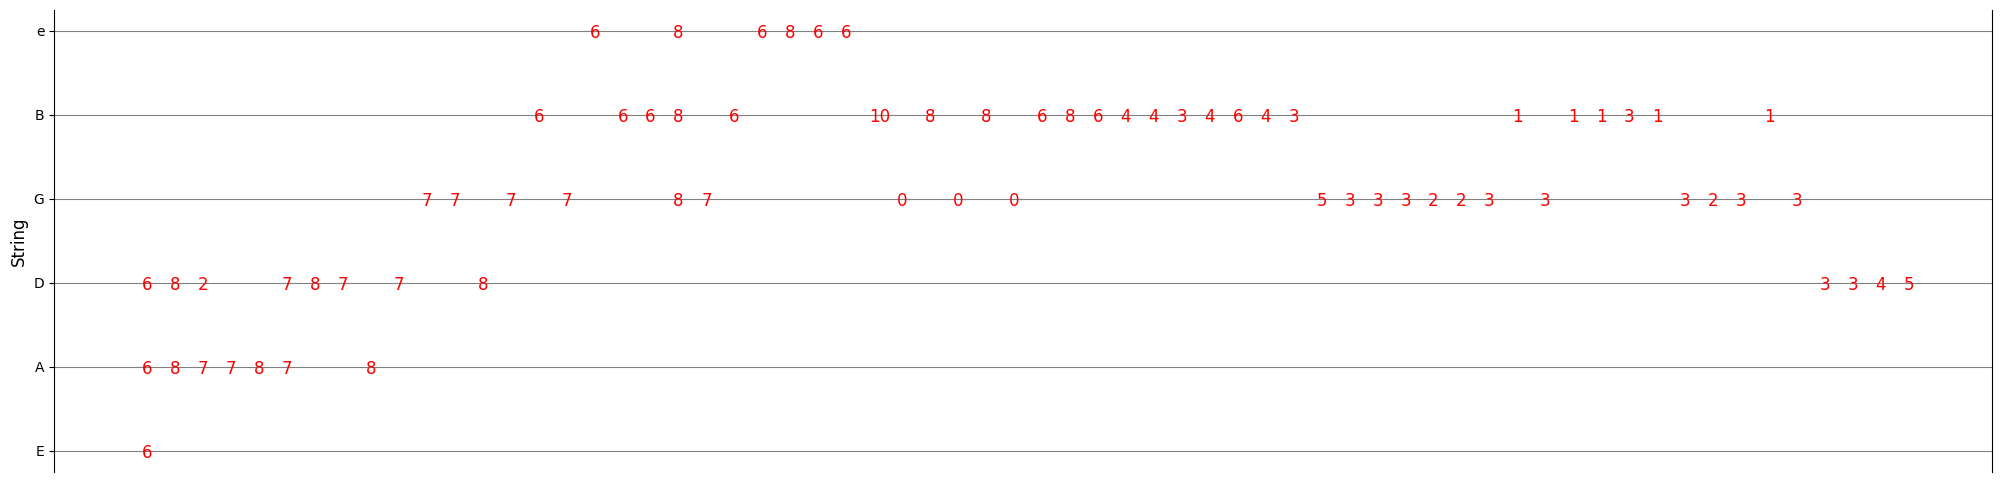

In [22]:
plot_tabs(postproc_df, idx_string=1, idx_fret=2, idx_pos=0)